In [2]:
import numpy as np
import nibabel as nib
import keras
import keras.backend as K
from keras.callbacks import CSVLogger
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.layers.experimental import preprocessing
import cv2

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
from keras.layers import GlobalAveragePooling2D, Reshape, Convolution2D

In [5]:
IMG_SIZE=128
SEGMENT_CLASSES = {
    0 : 'NOT tumor',
    1 : 'NECROTIC/CORE', 
    2 : 'EDEMA',
    3 : 'ENHANCING'}


VOLUME_SLICES = 128
VOLUME_START_AT = 22

In [6]:
TRAIN_DATASET_PATH = '/Users/sanjaydilli/Downloads/archive/BraTS2021_Training_Data'

In [7]:
import os
train_and_val_directories = [f.path for f in os.scandir(TRAIN_DATASET_PATH) if f.is_dir()]

In [8]:
def pathListIntoIds(dirList):
    x = []
    for i in range(0,len(dirList)):
        x.append(dirList[i][dirList[i].rfind('/')+1:])
    return x

train_and_test_ids = pathListIntoIds(train_and_val_directories);


train_test_ids, val_ids = train_test_split(train_and_test_ids,test_size=0.2)
train_ids, test_ids = train_test_split(train_test_ids,test_size=0.15)

In [10]:
def dice_coef(y_true, y_pred, smooth=1.0):
    class_num = 4
    for i in range(class_num):
        y_true_f = K.flatten(y_true[:,:,:,i])
        y_pred_f = K.flatten(y_pred[:,:,:,i])
        intersection = K.sum(y_true_f * y_pred_f)
        loss = ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))
        if i == 0:
            total_loss = loss
        else:
            total_loss = total_loss + loss
    total_loss = total_loss / class_num
    return total_loss

 

def dice_coef_necrotic(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,1] * y_pred[:,:,:,1]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,1])) + K.sum(K.square(y_pred[:,:,:,1])) + epsilon)

def dice_coef_edema(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,2] * y_pred[:,:,:,2]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,2])) + K.sum(K.square(y_pred[:,:,:,2])) + epsilon)

def dice_coef_enhancing(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,3] * y_pred[:,:,:,3]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,3])) + K.sum(K.square(y_pred[:,:,:,3])) + epsilon)


def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
     
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())



def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

In [27]:
keras = tf.compat.v1.keras
Sequence = keras.utils.Sequence

class DataGenerator(Sequence):
    
    def __init__(self, list_IDs, dim=(IMG_SIZE,IMG_SIZE), batch_size = 1, n_channels = 2, shuffle=True):
       
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        
        Batch_ids = [self.list_IDs[k] for k in indexes]

       
        X, y = self.__data_generation(Batch_ids)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, Batch_ids):
       
       
        X = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, self.n_channels))
        y = np.zeros((self.batch_size*VOLUME_SLICES, 128, 128))
        Y = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, 4))
        
        for c, i in enumerate(Batch_ids):
            case_path = os.path.join(TRAIN_DATASET_PATH, i)

            data_path = os.path.join(case_path, f'{i}_flair.nii.gz');
            flair = nib.load(data_path).get_fdata()

            data_path = os.path.join(case_path, f'{i}_t1ce.nii.gz');
            ce = nib.load(data_path).get_fdata()

            data_path = os.path.join(case_path, f'{i}_seg.nii.gz');
            seg = nib.load(data_path).get_fdata()

            for j in range(VOLUME_SLICES):
             X[j+(VOLUME_SLICES*c),:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))

             X[j+(VOLUME_SLICES*c),:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))


             y[j +VOLUME_SLICES*c,:,:] = cv2.resize(seg[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
       
       
        y[y==4] = 3;
        y = tf.one_hot(y, 4);
        return X/np.max(X), y

training_generator = DataGenerator(train_ids)
valid_generator = DataGenerator(val_ids)
test_generator = DataGenerator(test_ids)

In [28]:
csv_logger = CSVLogger('training.log', separator=',', append=False)


callbacks = [keras.callbacks.EarlyStopping(monitor='loss', min_delta=0,
                               patience=5, verbose=1, mode='auto'),
             keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=5,mode='max'),
      keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.0001, verbose=1),
      csv_logger
    ]

In [12]:
input_layer = Input((IMG_SIZE, IMG_SIZE, 2))

In [13]:
output_layer = Linknet(input_layer, 'he_normal',1e-4)

In [12]:
Linknet = tf.keras.Model(inputs=input_layer,outputs=output_layer)



AttributeError: module 'tensorflow.keras' has no attribute 'Model2'

In [15]:
Linknet.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=[
        'accuracy',
        tf.keras.metrics.MeanIoU(num_classes=4),
        dice_coef, 
        precision,
        sensitivity,
        specificity,
        dice_coef_necrotic,
        dice_coef_edema,
        dice_coef_enhancing
    ]
)

In [16]:
Linknet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 2  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 32)   3168        ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 64, 64, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

                                                                                                  
 conv2d_14 (Conv2D)             (None, 4, 4, 128)    147584      ['add_4[0][0]']                  
                                                                                                  
 batch_normalization_11 (BatchN  (None, 4, 4, 128)   512         ['conv2d_14[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 conv2d_15 (Conv2D)             (None, 4, 4, 128)    147584      ['batch_normalization_11[0][0]'] 
                                                                                                  
 batch_normalization_12 (BatchN  (None, 4, 4, 128)   512         ['conv2d_15[0][0]']              
 ormalization)                                                                                    
          

                                                                                                  
 conv2d_28 (Conv2D)             (None, 2, 2, 64)     16448       ['add_10[0][0]']                 
                                                                                                  
 batch_normalization_24 (BatchN  (None, 2, 2, 64)    256         ['conv2d_28[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 conv2d_transpose_1 (Conv2DTran  (None, 4, 4, 64)    36928       ['batch_normalization_24[0][0]'] 
 spose)                                                                                           
                                                                                                  
 batch_normalization_25 (BatchN  (None, 4, 4, 64)    256         ['conv2d_transpose_1[0][0]']     
 ormalizat

In [19]:
history =  Linknet.fit(training_generator,
                     epochs=30,
                     steps_per_epoch= 300,
                     callbacks= callbacks,
                     validation_data = valid_generator
                     )


Epoch 1/30


2023-12-18 09:29:36.462465: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-12-18 09:29:36.478475: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


300/300 [==============================] - ETA: 0s - loss: 1.2480 - accuracy: 0.9484 - mean_io_u: 0.3750 - dice_coef: 0.1415 - precision: 0.8191 - sensitivity: 0.1380 - specificity: 0.9977 - dice_coef_necrotic: 0.0251 - dice_coef_edema: 0.0677 - dice_coef_enhancing: 0.0263

2023-12-18 09:33:43.675361: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


300/300 [==============================] - 338s 1s/step - loss: 1.2480 - accuracy: 0.9484 - mean_io_u: 0.3750 - dice_coef: 0.1415 - precision: 0.8191 - sensitivity: 0.1380 - specificity: 0.9977 - dice_coef_necrotic: 0.0251 - dice_coef_edema: 0.0677 - dice_coef_enhancing: 0.0263 - val_loss: 0.8236 - val_accuracy: 0.9868 - val_mean_io_u: 0.3750 - val_dice_coef: 0.1727 - val_precision: 0.9874 - val_sensitivity: 0.2466 - val_specificity: 0.9990 - val_dice_coef_necrotic: 0.0256 - val_dice_coef_edema: 0.0584 - val_dice_coef_enhancing: 0.0241 - lr: 0.0010
Epoch 2/30
300/300 [==============================] - 343s 1s/step - loss: 0.6926 - accuracy: 0.9873 - mean_io_u: 0.3750 - dice_coef: 0.1863 - precision: 0.9933 - sensitivity: 0.2465 - specificity: 0.9994 - dice_coef_necrotic: 0.0324 - dice_coef_edema: 0.0810 - dice_coef_enhancing: 0.0336 - val_loss: 0.6013 - val_accuracy: 0.9840 - val_mean_io_u: 0.3750 - val_dice_coef: 0.1944 - val_precision: 0.9853 - val_sensitivity: 0.2426 - val_specifici

In [21]:
Linknet.save('Linknet.h5')

In [13]:
model = keras.models.load_model('/Users/sanjaydilli/Linknet/Linknet.h5', 
                                   custom_objects={ 'accuracy' : tf.keras.metrics.MeanIoU(num_classes=4),
                                                   "dice_coef": dice_coef,
                                                   "precision": precision,
                                                   "sensitivity":sensitivity,
                                                   "specificity":specificity,
                                                   "dice_coef_necrotic": dice_coef_necrotic,
                                                   "dice_coef_edema": dice_coef_edema,
                                                   "dice_coef_enhancing": dice_coef_enhancing
                                                  }, compile=False)


In [11]:
def Linknet(inputs, initialization,regularization):
    conv1 = Conv2D(32,7,strides=2, kernel_initializer=initialization, kernel_regularizer=tf.keras.regularizers.l2(regularization), padding="same",activation='relu')(input_layer)
    conv1 = BatchNormalization()(conv1)
    conv1 = MaxPool2D(3, strides=2)(conv1)

    encoder1 = Conv2D(32,3,2, kernel_initializer=initialization, kernel_regularizer=tf.keras.regularizers.l2(regularization), padding="same",activation='relu')(conv1)
    b1  = BatchNormalization()(encoder1)
    encoder1 =  Conv2D(32,3, kernel_initializer=initialization, kernel_regularizer=tf.keras.regularizers.l2(regularization), padding="same",activation='relu')(b1)
    b1 = BatchNormalization()(encoder1)
    encoder1 =  Conv2D(32,1,2, kernel_initializer=initialization, kernel_regularizer=tf.keras.regularizers.l2(regularization), padding="same",activation='relu')(conv1)
    encoder_1 = tf.keras.layers.add([b1,encoder1])
    encoder1 = Conv2D(32,3,1, kernel_initializer=initialization, kernel_regularizer=tf.keras.regularizers.l2(regularization), padding="same",activation='relu')(encoder_1)
    b1  = BatchNormalization()(encoder1)
    encoder1 =  Conv2D(32,3, kernel_initializer=initialization, kernel_regularizer=tf.keras.regularizers.l2(regularization), padding="same",activation='relu')(b1)
    b1 = BatchNormalization()(encoder1)
    encoder1 = tf.keras.layers.add([b1,encoder_1])

    encoder2 = Conv2D(64,3,2, kernel_initializer=initialization, kernel_regularizer=tf.keras.regularizers.l2(regularization), padding="same",activation='relu')(encoder1)
    b2  = BatchNormalization()(encoder2)
    encoder2 =  Conv2D(64,3, kernel_initializer=initialization, kernel_regularizer=tf.keras.regularizers.l2(regularization), padding="same",activation='relu')(b2)
    b2 = BatchNormalization()(encoder2)
    encoder2 =  Conv2D(64,1,2, kernel_initializer=initialization, kernel_regularizer=tf.keras.regularizers.l2(regularization), padding="same",activation='relu')(encoder1)
    encoder_2 = tf.keras.layers.add([b2,encoder2])
    encoder2 = Conv2D(64,3,1, kernel_initializer=initialization, kernel_regularizer=tf.keras.regularizers.l2(regularization), padding="same",activation='relu')(encoder_2)
    b2  = BatchNormalization()(encoder2)
    encoder2 =  Conv2D(64,3, kernel_initializer=initialization, kernel_regularizer=tf.keras.regularizers.l2(regularization), padding="same",activation='relu')(b2)
    b2 = BatchNormalization()(encoder2)
    encoder2 = tf.keras.layers.add([b2,encoder_2])

    encoder3 = Conv2D(128,3,2, kernel_initializer=initialization, kernel_regularizer=tf.keras.regularizers.l2(regularization), padding="same",activation='relu')(encoder2)
    b3  = BatchNormalization()(encoder3)
    encoder3 =  Conv2D(128,3, kernel_initializer=initialization, kernel_regularizer=tf.keras.regularizers.l2(regularization), padding="same",activation='relu')(b3)
    b3 = BatchNormalization()(encoder3)
    encoder3 =  Conv2D(128,1,2, kernel_initializer=initialization, kernel_regularizer=tf.keras.regularizers.l2(regularization), padding="same",activation='relu')(encoder2)
    encoder_3 = tf.keras.layers.add([b3,encoder3])
    encoder3 = Conv2D(128,3,1, kernel_initializer=initialization, kernel_regularizer=tf.keras.regularizers.l2(regularization), padding="same",activation='relu')(encoder_3)
    b3  = BatchNormalization()(encoder3)
    encoder3 =  Conv2D(128,3, kernel_initializer=initialization, kernel_regularizer=tf.keras.regularizers.l2(regularization), padding="same",activation='relu')(b3)
    b3 = BatchNormalization()(encoder3)
    encoder3 = tf.keras.layers.add([b3,encoder_3])

    encoder4 = Conv2D(256,3,2, kernel_initializer=initialization, kernel_regularizer=tf.keras.regularizers.l2(regularization), padding="same",activation='relu')(encoder3)
    b4  = BatchNormalization()(encoder4)
    encoder4 =  Conv2D(256,3, kernel_initializer=initialization, kernel_regularizer=tf.keras.regularizers.l2(regularization), padding="same",activation='relu')(b4)
    b4 = BatchNormalization()(encoder4)
    encoder4 =  Conv2D(256,1,2, kernel_initializer=initialization, kernel_regularizer=tf.keras.regularizers.l2(regularization), padding="same",activation='relu')(encoder3)
    encoder_4 = tf.keras.layers.add([b4,encoder4])
    encoder4 = Conv2D(256,3,1, kernel_initializer=initialization, kernel_regularizer=tf.keras.regularizers.l2(regularization), padding="same",activation='relu')(encoder_4)
    b3  = BatchNormalization()(encoder4)
    encoder4 =  Conv2D(256,3, kernel_initializer=initialization, kernel_regularizer=tf.keras.regularizers.l2(regularization), padding="same",activation='relu')(b4)
    b4 = BatchNormalization()(encoder4)
    encoder4 = tf.keras.layers.add([b4,encoder_4])

    encoder5 = Conv2D(512,3,2, kernel_initializer=initialization, kernel_regularizer=tf.keras.regularizers.l2(regularization), padding="same",activation='relu')(encoder4)
    b5  = BatchNormalization()(encoder5)
    encoder5 =  Conv2D(512,3, kernel_initializer=initialization, kernel_regularizer=tf.keras.regularizers.l2(regularization), padding="same",activation='relu')(b5)
    b5 = BatchNormalization()(encoder5)
    encoder5 =  Conv2D(512,1,2, kernel_initializer=initialization, kernel_regularizer=tf.keras.regularizers.l2(regularization), padding="same",activation='relu')(encoder4)
    encoder_5 = tf.keras.layers.add([b5,encoder5])
    encoder5 = Conv2D(512,3,1, kernel_initializer=initialization, kernel_regularizer=tf.keras.regularizers.l2(regularization), padding="same",activation='relu')(encoder_5)
    b5  = BatchNormalization()(encoder5)
    encoder5 =  Conv2D(512,3, kernel_initializer=initialization, kernel_regularizer=tf.keras.regularizers.l2(regularization), padding="same",activation='relu')(b5)
    b5 = BatchNormalization()(encoder5)
    encoder5 = tf.keras.layers.add([b5,encoder_5])

    decoder1 =  Conv2D(128,1, kernel_initializer=initialization, kernel_regularizer=tf.keras.regularizers.l2(regularization), padding="same",activation='relu')(encoder5)
    decoder1 = BatchNormalization()(decoder1)
    decoder1 = Conv2DTranspose(128,3,2, kernel_initializer=initialization, kernel_regularizer=tf.keras.regularizers.l2(regularization), padding="same",activation='relu')(decoder1)
    decoder1 = BatchNormalization()(decoder1)
    decoder1 = Conv2D(256,1, kernel_initializer=initialization, kernel_regularizer=tf.keras.regularizers.l2(regularization), padding="same",activation='relu')(decoder1)
    decoder1 = BatchNormalization()(decoder1)

    decoder2 = tf.keras.layers.add([decoder1, encoder4])
    
    decoder2 =  Conv2D(64,1, kernel_initializer=initialization, kernel_regularizer=tf.keras.regularizers.l2(regularization), padding="same",activation='relu')(decoder2)
    decoder2 = BatchNormalization()(decoder2)
    decoder2 = Conv2DTranspose(64,3,2, kernel_initializer=initialization, kernel_regularizer=tf.keras.regularizers.l2(regularization), padding="same",activation='relu')(decoder2)
    decoder2 = BatchNormalization()(decoder2)
    decoder2 = Conv2D(128,1, kernel_initializer=initialization, kernel_regularizer=tf.keras.regularizers.l2(regularization), padding="same",activation='relu')(decoder2)
    decoder2 = BatchNormalization()(decoder2)

    decoder3 = tf.keras.layers.add([decoder2, encoder3])


    decoder3 =  Conv2D(32,1, kernel_initializer=initialization, kernel_regularizer=tf.keras.regularizers.l2(regularization), padding="same",activation='relu')(decoder3)
    decoder3 = BatchNormalization()(decoder3)
    decoder3 = Conv2DTranspose(32,3,2, kernel_initializer=initialization, kernel_regularizer=tf.keras.regularizers.l2(regularization), padding="same",activation='relu')(decoder3)
    decoder3 = BatchNormalization()(decoder3)
    decoder3 = Conv2D(64,1, kernel_initializer=initialization, kernel_regularizer=tf.keras.regularizers.l2(regularization), padding="same",activation='relu')(decoder3)
    decoder3 = BatchNormalization()(decoder3)

    decoder4 = tf.keras.layers.add([decoder3, encoder2])

    decoder4 =  Conv2D(16,1, kernel_initializer=initialization, kernel_regularizer=tf.keras.regularizers.l2(regularization), padding="same",activation='relu')(decoder4)
    decoder4 = BatchNormalization()(decoder4)
    decoder4 = Conv2DTranspose(16,3,2, kernel_initializer=initialization, kernel_regularizer=tf.keras.regularizers.l2(regularization), padding="same",activation='relu')(decoder4)
    decoder4 = BatchNormalization()(decoder4)
    decoder4 = Conv2D(32,1, kernel_initializer=initialization, kernel_regularizer=tf.keras.regularizers.l2(regularization), padding="same",activation='relu')(decoder4)
    decoder4 = BatchNormalization()(decoder4)

    decoder5 = tf.keras.layers.add([decoder4, encoder1])

    output =  Conv2DTranspose(16,3,2, kernel_initializer=initialization, kernel_regularizer=tf.keras.regularizers.l2(regularization), padding="same",activation='relu')(decoder5)
    output = BatchNormalization()(output)
    output = Conv2D(16,3, kernel_initializer=initialization, kernel_regularizer=tf.keras.regularizers.l2(regularization), padding="same",activation='relu')(output)
    output = BatchNormalization()(output)
    output = Conv2DTranspose(4,2,4, kernel_initializer=initialization, kernel_regularizer=tf.keras.regularizers.l2(regularization), padding="same",activation='softmax')(output)
    return output



In [15]:
model._name = 'Linknet'

In [16]:
model.summary()

Model: "Linknet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 2  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 32)   3168        ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 64, 64, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                            

                                                                                                  
 conv2d_14 (Conv2D)             (None, 4, 4, 128)    147584      ['add_4[0][0]']                  
                                                                                                  
 batch_normalization_11 (BatchN  (None, 4, 4, 128)   512         ['conv2d_14[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 conv2d_15 (Conv2D)             (None, 4, 4, 128)    147584      ['batch_normalization_11[0][0]'] 
                                                                                                  
 batch_normalization_12 (BatchN  (None, 4, 4, 128)   512         ['conv2d_15[0][0]']              
 ormalization)                                                                                    
          

                                                                                                  
 conv2d_28 (Conv2D)             (None, 2, 2, 64)     16448       ['add_10[0][0]']                 
                                                                                                  
 batch_normalization_24 (BatchN  (None, 2, 2, 64)    256         ['conv2d_28[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 conv2d_transpose_1 (Conv2DTran  (None, 4, 4, 64)    36928       ['batch_normalization_24[0][0]'] 
 spose)                                                                                           
                                                                                                  
 batch_normalization_25 (BatchN  (None, 4, 4, 64)    256         ['conv2d_transpose_1[0][0]']     
 ormalizat

In [31]:
model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema, dice_coef_enhancing] )


In [29]:
import nibabel as nib

In [36]:
history = pd.read_csv('/Users/sanjaydilli/Linknet/training.log', sep=',', engine='python')
hist=history

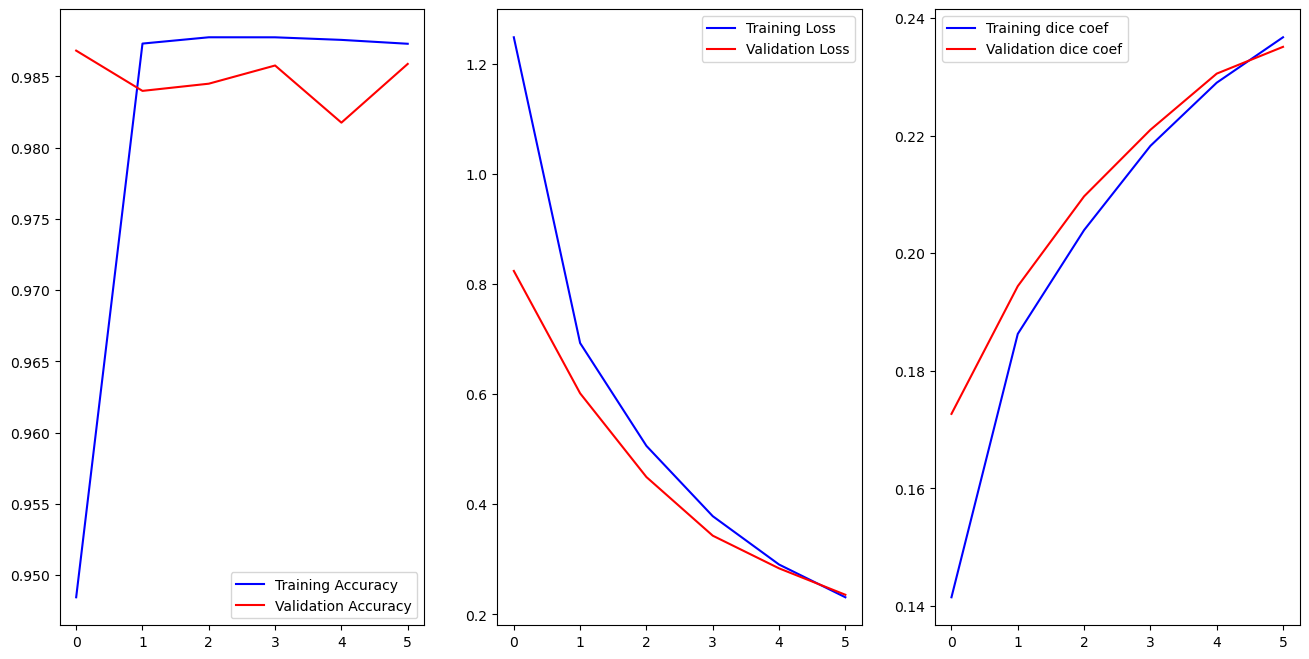

In [37]:
acc=hist['accuracy']
val_acc=hist['val_accuracy']

epoch=range(len(acc))

loss=hist['loss']
val_loss=hist['val_loss']

train_dice=hist['dice_coef']
val_dice=hist['val_dice_coef']

f,ax=plt.subplots(1,3,figsize=(16,8))

ax[0].plot(epoch,acc,'b',label='Training Accuracy')
ax[0].plot(epoch,val_acc,'r',label='Validation Accuracy')
ax[0].legend()

ax[1].plot(epoch,loss,'b',label='Training Loss')
ax[1].plot(epoch,val_loss,'r',label='Validation Loss')
ax[1].legend()

ax[2].plot(epoch,train_dice,'b',label='Training dice coef')
ax[2].plot(epoch,val_dice,'r',label='Validation dice coef')
ax[2].legend()



plt.show()

In [32]:
print("Evaluate on test data")
results = model.evaluate(test_generator, callbacks= callbacks)
print("test loss, test acc:", results)

Evaluate on test data


2023-12-19 13:50:59.712290: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-12-19 13:50:59.784778: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


150/150 [==============================] - 101s 659ms/step - loss: 0.2350 - accuracy: 0.9861 - mean_io_u_2: 0.3767 - dice_coef: 0.2353 - precision: 0.9864 - sensitivity: 0.9860 - specificity: 0.9955 - dice_coef_necrotic: 0.0440 - dice_coef_edema: 0.0792 - dice_coef_enhancing: 0.0449
test loss, test acc: [0.23501014709472656, 0.986131489276886, 0.376654714345932, 0.23526430130004883, 0.986397385597229, 0.9859784841537476, 0.9954684376716614, 0.044017765671014786, 0.07921892404556274, 0.04489392787218094]


In [11]:
def predictByPath(case_path,case):
    files = next(os.walk(case_path))[2]
    X = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 2))
 
    
    vol_path = os.path.join(case_path, f'BraTS2021{case}_flair.nii.gz');
    flair=nib.load(vol_path).get_fdata()
    
    vol_path = os.path.join(case_path, f'BraTS2021{case}_t1ce.nii.gz');
    ce=nib.load(vol_path).get_fdata() 
    

    
    for j in range(VOLUME_SLICES):
        X[j,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
        X[j,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
 
    return model.predict(X/np.max(X), verbose=1)


In [15]:
def showPredictsById(case, start_slice = 60):
    path = f"/Users/sanjaydilli/Downloads/archive/BraTS2021_Training_Data/BraTS2021{case}"
    gt = nib.load(os.path.join(path, f'BraTS2021{case}_seg.nii.gz')).get_fdata()
    origImage = nib.load(os.path.join(path,f'BraTS2021{case}_flair.nii.gz')).get_fdata()
    p = predictByPath(path,case)

    core = p[:,:,:,1]
    edema= p[:,:,:,2]
    enhancing = p[:,:,:,3]

    plt.figure(figsize=(18, 50))
    f, axarr = plt.subplots(1,6, figsize = (18, 50)) 

    for i in range(6):
        axarr[i].imshow(cv2.resize(origImage[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray", interpolation='none')
    
    axarr[0].imshow(cv2.resize(origImage[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray")
    axarr[0].title.set_text('Original image flair')
    curr_gt=cv2.resize(gt[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE), interpolation = cv2.INTER_NEAREST)
    axarr[1].imshow(curr_gt, cmap="Reds", interpolation='none', alpha=0.3) # ,alpha=0.3,cmap='Reds'
    axarr[1].title.set_text('Ground truth')
    axarr[2].imshow(p[start_slice,:,:,1:4], cmap="Reds", interpolation='none', alpha=0.3)
    axarr[2].title.set_text('all classes')
    axarr[3].imshow(edema[start_slice,:,:], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[3].title.set_text(f'{SEGMENT_CLASSES[1]} predicted')
    axarr[4].imshow(core[start_slice,:,], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[4].title.set_text(f'{SEGMENT_CLASSES[2]} predicted')
    axarr[5].imshow(enhancing[start_slice,:,], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[5].title.set_text(f'{SEGMENT_CLASSES[3]} predicted')
    plt.show()
    

4/4 [==============================] - 0s 39ms/step


<Figure size 1800x5000 with 0 Axes>

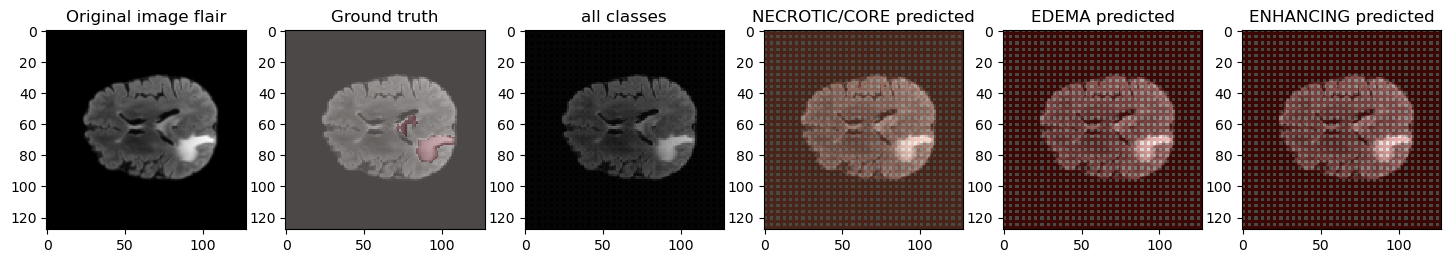

In [16]:
showPredictsById(case=test_ids[1][-6:])
